In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as ss
import h5py
import json
import os

from analysis import plot, process

network_name = 'v1'

### Trial settings

In [2]:
setting_properties = ['duration_window', 'logscale_fr']
settings = {
    'drifting_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 3.)}, # seconds
        {'baseline': False, 'drifting_grating': True}
    ],
    'different_grating': [
        {'baseline': (.1,  .5), 'drifting_grating': (.5, 2.)}, # seconds
        {'baseline': False, 'drifting_grating': True}
    ],
    'movie_5s': [
        {'movie': (.1,  3.)},
        {'movie': True}
    ],
    'movie_2.5s': [
        {'movie': (.1,  2.5)},
        {'movie': True}
    ]
}
settings = pd.DataFrame.from_dict(settings, orient='index', columns=setting_properties)
settings

duration_window  \
drifting_grating   {'baseline': (0.1, 0.5), 'drifting_grating': (...   
different_grating  {'baseline': (0.1, 0.5), 'drifting_grating': (...   
movie_5s                                       {'movie': (0.1, 3.0)}   
movie_2.5s                                     {'movie': (0.1, 2.5)}   

                                                     logscale_fr  
drifting_grating   {'baseline': False, 'drifting_grating': True}  
different_grating  {'baseline': False, 'drifting_grating': True}  
movie_5s                                         {'movie': True}  
movie_2.5s                                       {'movie': True}

#### Select trial

In [3]:
trial_name = 'output_drifting'
setting_name = 'drifting_grating'

# trial_name = 'output_different_thetas'
# setting_name = 'different_grating'

# trial_name = 'output_changed_weight_drifting_LGN2PV_0.5_LGN2PN_1.5_PN2PV_3_PV2PN1.5_movie_4.0'
# setting_name = 'different_grating'

# trial_name = 'output_movie_v_report_tau_4.0_PN2PV_10_PV2PN_10_PV2PV_0.5_BG2PN_1.5_SOM2PV_0.1'
# setting_name = 'movie_2.5s'

setting = settings.loc[setting_name]

#### Common parameters

In [4]:
params = dict(
    nbins = 30, # number of firing rate histogram bins
    dt = 2., # ms. spike time histogram bin width
    grating_angle = 270.,  # deg. angle of grating direction
)

### File paths

In [5]:
output_dir = os.path.join('..', 'V1_bio_outputs', trial_name)
data_dir = os.path.join('.', 'data')
trial_dir = os.path.join(data_dir, trial_name)

config_file = os.path.join(output_dir, 'config.json')
spikes_file = os.path.join(output_dir, 'spikes.h5')

if not os.path.isdir(trial_dir):
    os.mkdir(trial_dir)

### Load nodes information

In [6]:
v1_pop_df = pd.read_csv(os.path.join(data_dir, 'v1_population_properties.csv'),
                        index_col='pop_name', dtype={'layer': str})

bio_idx = v1_pop_df['model_type'] == 'biophysical'
bio_pop_names = v1_pop_df.index[bio_idx].tolist()
lif_pop_names = v1_pop_df.index[~bio_idx].tolist()

v1_bio_nodes = pd.read_csv(os.path.join(data_dir, 'v1_biophysical_nodes.csv'), index_col='node_id')
v1_lif_nodes = pd.read_csv(os.path.join(data_dir, 'v1_point_process_nodes.csv'), index_col='node_id')
v1_nodes = pd.concat((v1_bio_nodes, v1_lif_nodes))

In [7]:
# IDs sorted by tuning angle for raster plot in a reverse order of layers
for nodes, pop_names in zip([v1_bio_nodes, v1_lif_nodes], [bio_pop_names, lif_pop_names]):
    nodes['angle_diff'] = 180. - np.abs(180. - \
        np.mod(nodes['tuning_angle'] - params['grating_angle'], 360.))
    nodes['angle_id'] = nodes.index
    n = len(nodes)
    for p in pop_names:
        idx = nodes['pop_name'] == p
        n_pop = idx.sum()
        sort_idx = np.argsort(nodes.loc[idx, 'angle_diff'])
        angle_idx = np.zeros_like(sort_idx)
        angle_idx[sort_idx] = range(sort_idx.size)
        nodes.loc[idx, 'angle_id'] = n - n_pop + angle_idx
        n -= n_pop

### Load spikes

In [8]:
with h5py.File(spikes_file) as f:
    spikes_df = pd.DataFrame({
        'node_ids': f['spikes'][network_name]['node_ids'],
        'timestamps': f['spikes'][network_name]['timestamps']
    })

# choose only biophysical cells
bio_idx = np.array([nid in v1_bio_nodes.index for nid in spikes_df['node_ids']])
spikes_bio_df = spikes_df[bio_idx].copy()
spikes_bio_df.sort_values(by='timestamps', inplace=True, ignore_index=True)
spikes_lif_df = spikes_df[~bio_idx].copy()
spikes_lif_df.sort_values(by='timestamps', inplace=True, ignore_index=True)

# spikes of populations
columns = ['pop_name', 'raster_id', 'depth_id', 'angle_id']
spikes_bio_df[columns] = v1_bio_nodes.loc[spikes_bio_df['node_ids'], columns].values
pop_spike_bio = process.get_populations(spikes_bio_df, bio_pop_names)
spikes_lif_df[columns] = v1_lif_nodes.loc[spikes_lif_df['node_ids'], columns].values
pop_spike_lif = process.get_populations(spikes_lif_df, lif_pop_names)

### Raster plot

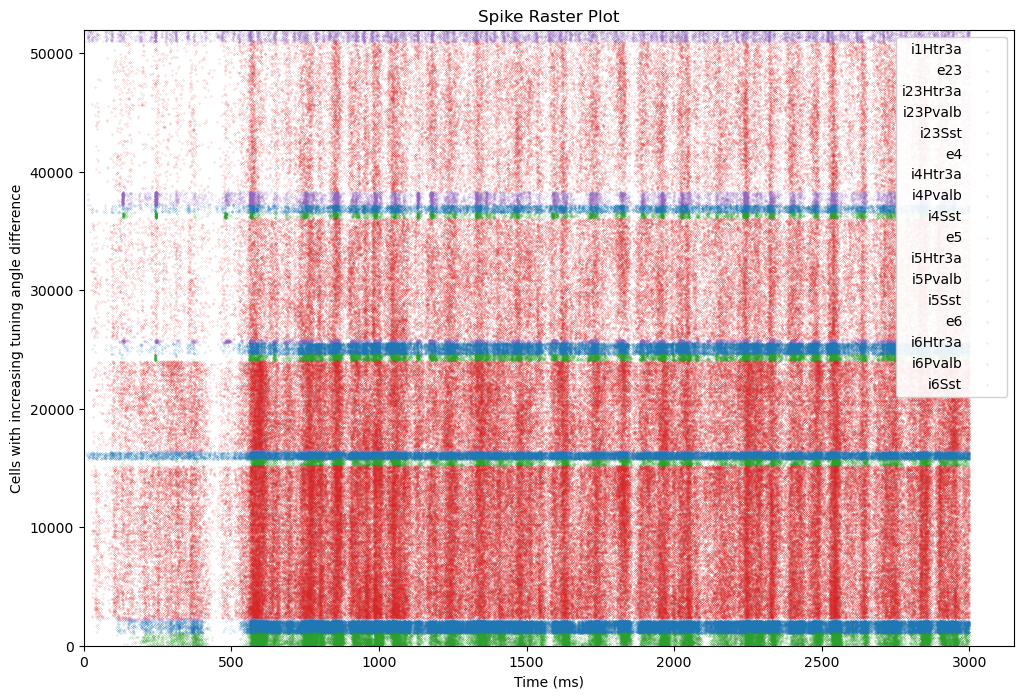

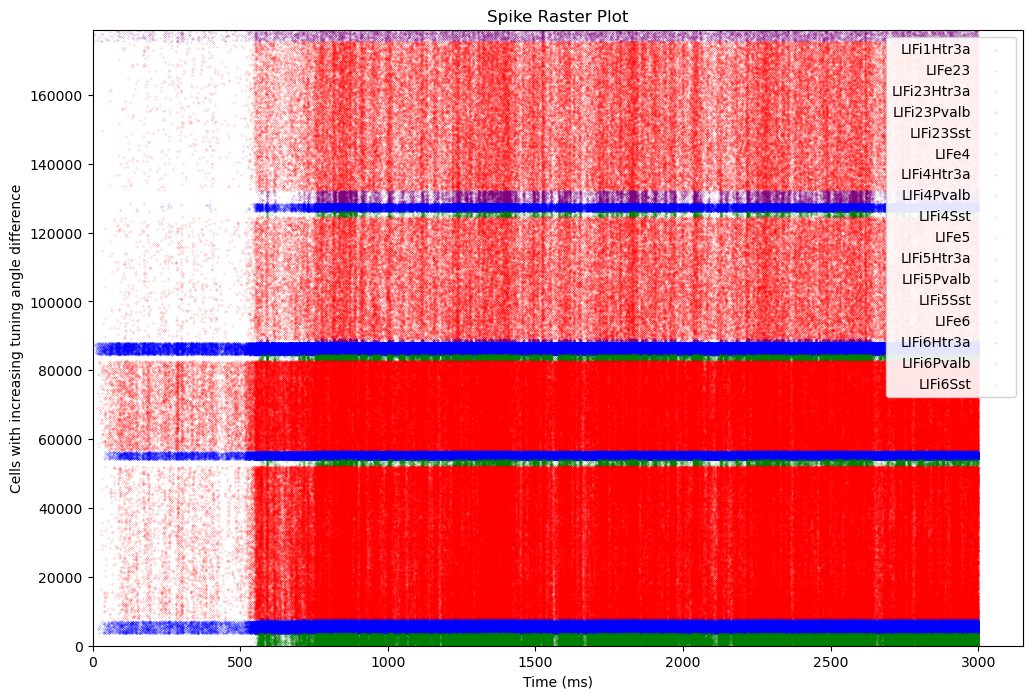

In [9]:
id_column = 'angle_id' # 'raster_id', 'depth_id' or 'angle_id'
ylabel = {
    'raster_id': 'Cells in acsending layers',
    'depth_id': 'Cells with decreasing depth',
    'angle_id': 'Cells with increasing tuning angle difference',
}
# population filter: column and list of values in v1_pop_df
pop_filter = {}  # {'layer': ['4', '5']}

pop_filt = v1_pop_df.index[np.all(np.reshape(
    [v1_pop_df[col].isin(vals) for col, vals in pop_filter.items()],
    (-1, len(v1_pop_df))), axis=0)]
for pop_spike in [pop_spike_bio, pop_spike_lif]:
    pop_spike = {p: pop_spike[p] for p in pop_spike if p in pop_filt}
    _, ax = plt.subplots(1, 1, figsize=(12, 8))
    _ = plot.raster(pop_spike, v1_pop_df['color'].to_dict(), id_column=id_column, s=0.01, ax=ax)
    ax.set_ylabel(ylabel[id_column])
plt.show()

### Firing rate

In [10]:
v1_pop_ids = process.get_populations(v1_nodes, v1_pop_df.index, only_id=True)
layers = v1_pop_df['layer'].unique()
model_types = v1_pop_df['model_type'].unique()[::-1]

In [11]:
durations = list(setting.duration_window.keys())
firing_rates = {}
pop_frs = {}
for dur in durations:
    frs = process.firing_rate(spikes_df, num_cells=len(v1_nodes), time_windows=setting.duration_window[dur])
    firing_rates[dur] = frs
    pop_frs[dur] = {p: frs[nid] for p, nid in v1_pop_ids.items()}

    pop_frs_df = process.population_statistics(pop_frs[dur])
    print(f'{dur} firing rate (Hz)')
    display(pop_frs_df)

    # save to file
    pop_frs_df.to_csv(os.path.join(trial_dir, dur + '_firing_rate_statisitcs.csv'))

baseline firing rate (Hz)


mean     stdev
pop_name                       
LIFi1Htr3a   0.156064  0.657791
i1Htr3a      1.531532  3.196400
LIFe23       0.022597  0.253656
e23          0.161951  0.693614
LIFi23Htr3a  0.000000  0.000000
i23Htr3a     2.152213  3.343967
LIFi23Pvalb  0.021863  0.232763
i23Pvalb     1.007812  1.926364
LIFi23Sst    0.000000  0.000000
i23Sst       1.250000  2.852328
LIFe4        0.041823  0.344966
e4           0.364004  1.081684
LIFi4Htr3a   0.000000  0.000000
i4Htr3a      2.407407  3.079313
LIFi4Pvalb   3.389079  3.757876
i4Pvalb      0.443925  1.315485
LIFi4Sst     0.000000  0.000000
i4Sst        0.298373  0.927546
LIFe5        0.628439  1.542581
e5           1.354869  2.864199
LIFi5Htr3a   0.000000  0.000000
i5Htr3a      2.222222  4.585114
LIFi5Pvalb   2.359700  2.903227
i5Pvalb      4.094617  6.801786
LIFi5Sst     0.000000  0.000000
i5Sst        0.193694  0.805866
LIFe6        0.175090  0.795070
e6           1.533341  3.157197
LIFi6Htr3a   0.000000  0.000000
i6Htr3a      2.864583  6.841578
LIFi6Pvalb   1.579463  2.595891
i6Pvalb      2.295627  4.989872
LIFi6Sst     0.001402  0.059181
i6Sst        1.692635  4.352254

drifting_grating firing rate (Hz)


mean      stdev
pop_name                         
LIFi1Htr3a    1.020927   1.845131
i1Htr3a       3.218819   3.931277
LIFe23        1.196117   1.796854
e23           1.354086   1.510146
LIFi23Htr3a   1.651043   1.820073
i23Htr3a      3.421861   3.641127
LIFi23Pvalb   9.041014   6.523072
i23Pvalb      6.746250   6.214066
LIFi23Sst     1.202899   1.453695
i23Sst        3.768103   6.644029
LIFe4         1.273608   1.802413
e4            2.307743   2.380637
LIFi4Htr3a    2.536941   2.195080
i4Htr3a       7.330370   3.138041
LIFi4Pvalb   20.569926   9.022157
i4Pvalb      11.671859   7.909330
LIFi4Sst      5.473949   4.038711
i4Sst         7.698373   5.935556
LIFe5         5.126030   5.021922
e5            4.489365   5.396027
LIFi5Htr3a    4.576982   3.446423
i5Htr3a       7.565812   8.371473
LIFi5Pvalb   20.876359   7.147981
i5Pvalb      16.957912  14.173020
LIFi5Sst      2.478870   2.417250
i5Sst         6.273153   4.137604
LIFe6         4.864774   4.463497
e6            5.612017   4.348654
LIFi6Htr3a    9.252388   5.729041
i6Htr3a       2.072917   5.667791
LIFi6Pvalb   22.069950  11.125879
i6Pvalb      23.803422  14.770605
LIFi6Sst      9.757892   6.820869
i6Sst         8.975260   6.344241

baseline


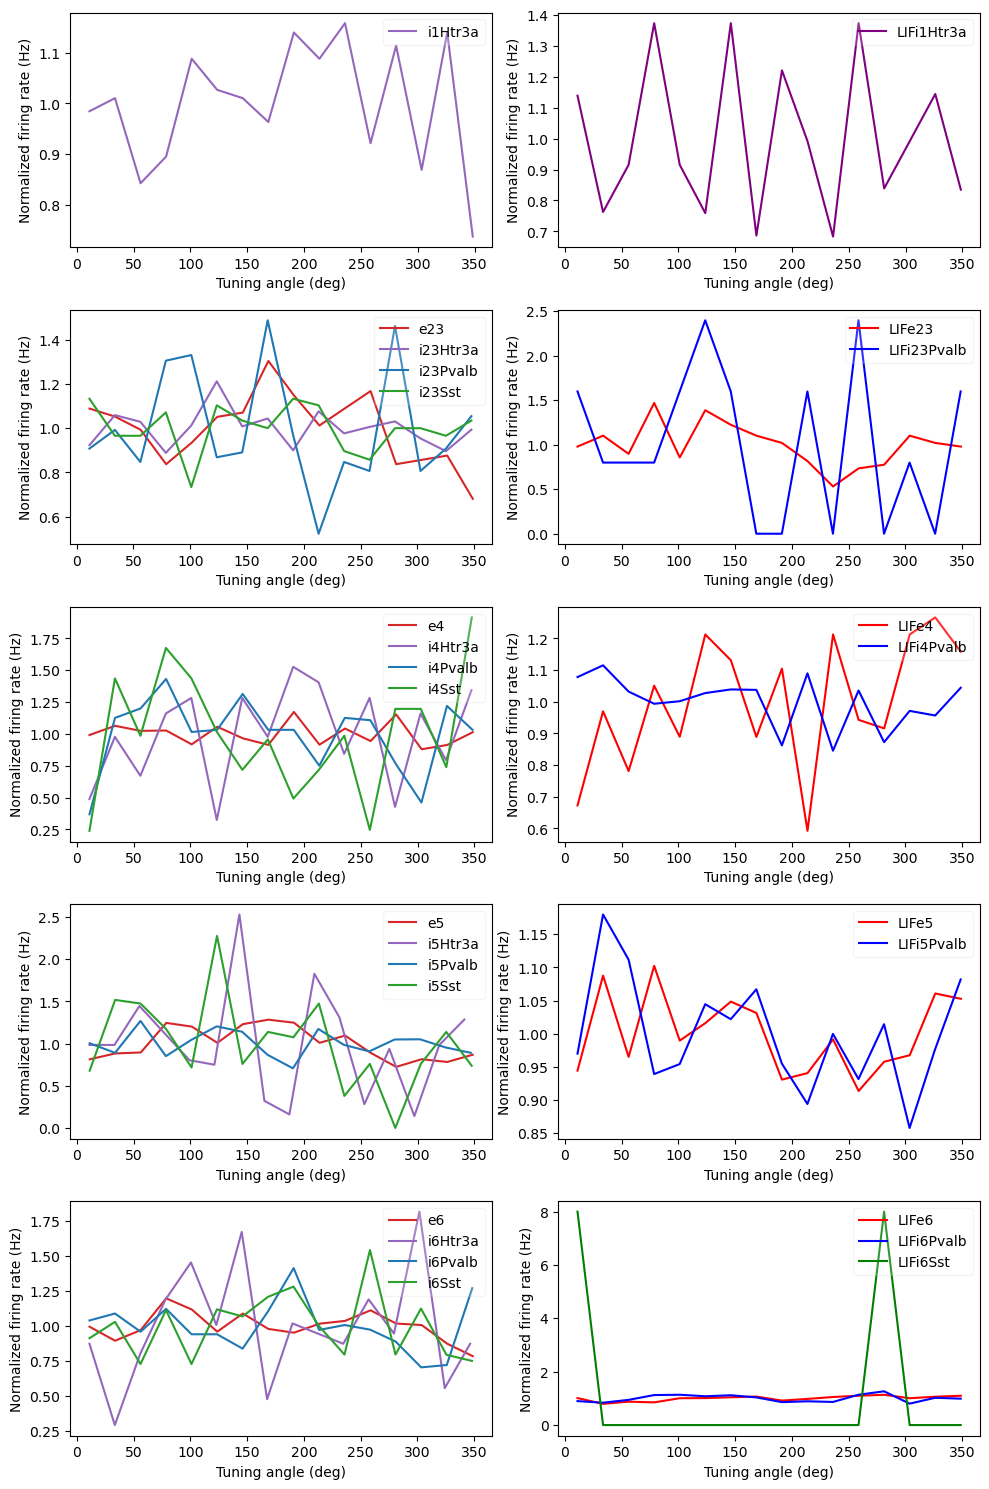

drifting_grating


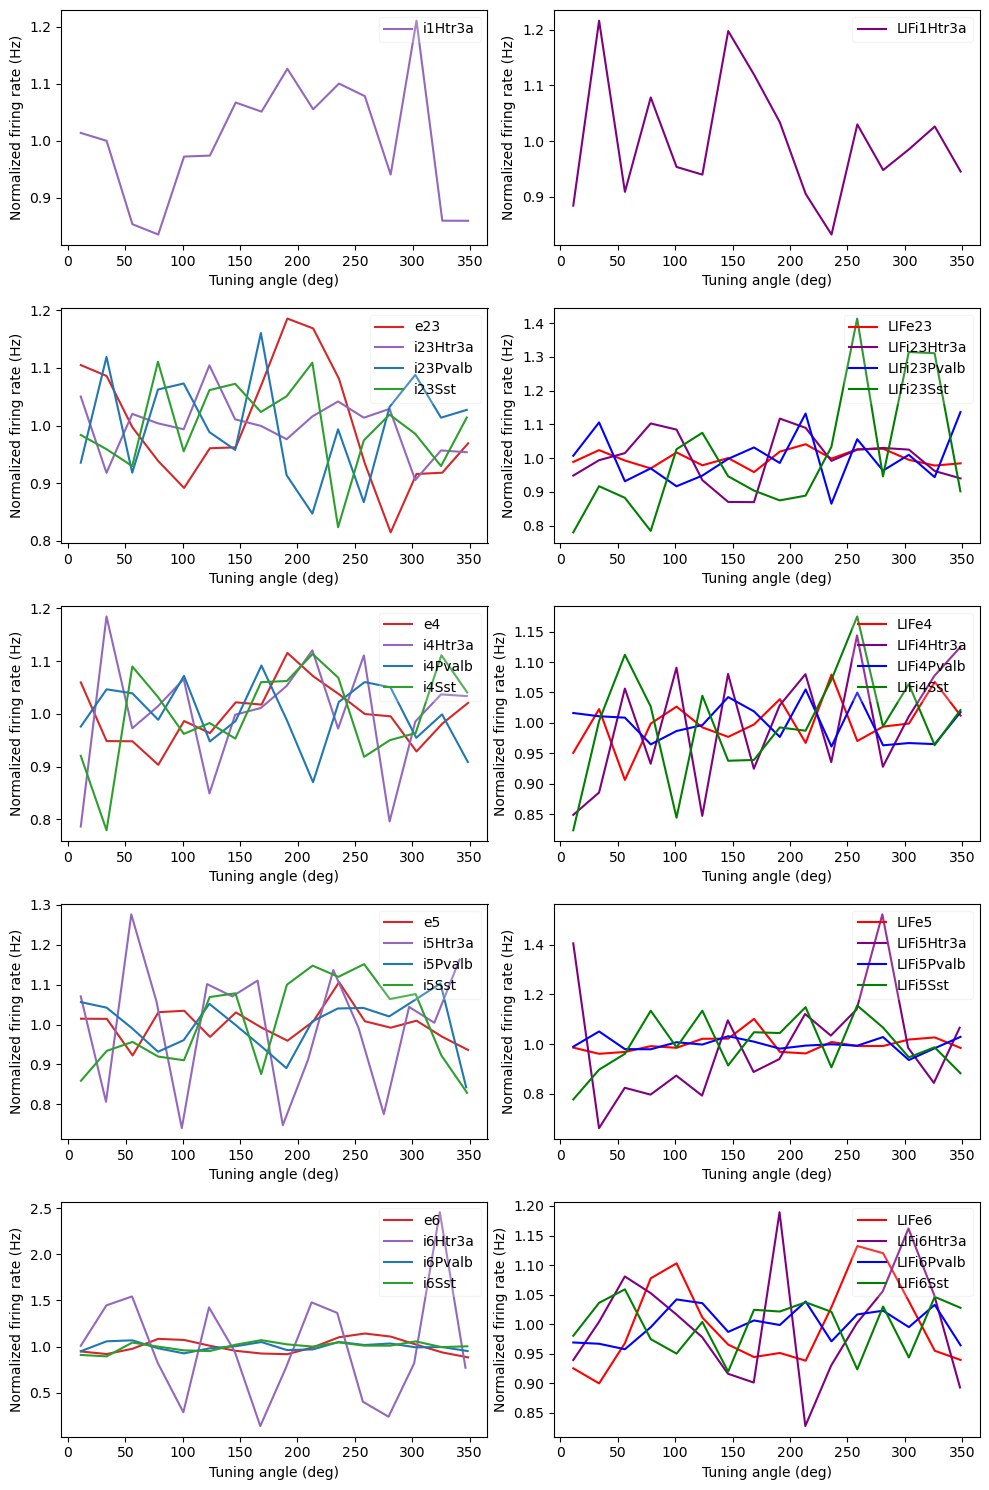

In [12]:
for dur in durations:
    print(dur)
    _, axs = plt.subplots(len(layers), 2, figsize=(10, 3 * len(layers)))
    for j, M in enumerate(model_types):
        for i, L in enumerate(layers):
            ax = axs[i, j]
            pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
            for p in pops:
                tuning_angle = v1_nodes.loc[v1_pop_ids[p], 'tuning_angle']
                fr = pop_frs[dur][p]
                if not np.any(fr):
                    continue
                fr = fr / fr.mean()
                fr_mean, angles, _ = sp.stats.binned_statistic(tuning_angle, fr,
                                                               statistic='mean', bins=16)
                ax.plot((angles[1:] + angles[:-1]) / 2, fr_mean,
                        color=v1_pop_df.loc[p, 'color'], label=p)
            ax.set_xlabel('Tuning angle (deg)')
            ax.set_ylabel('Normalized firing rate (Hz)')
            ax.legend(loc='upper right', framealpha=0.2)
    plt.tight_layout()
    plt.show()

baseline


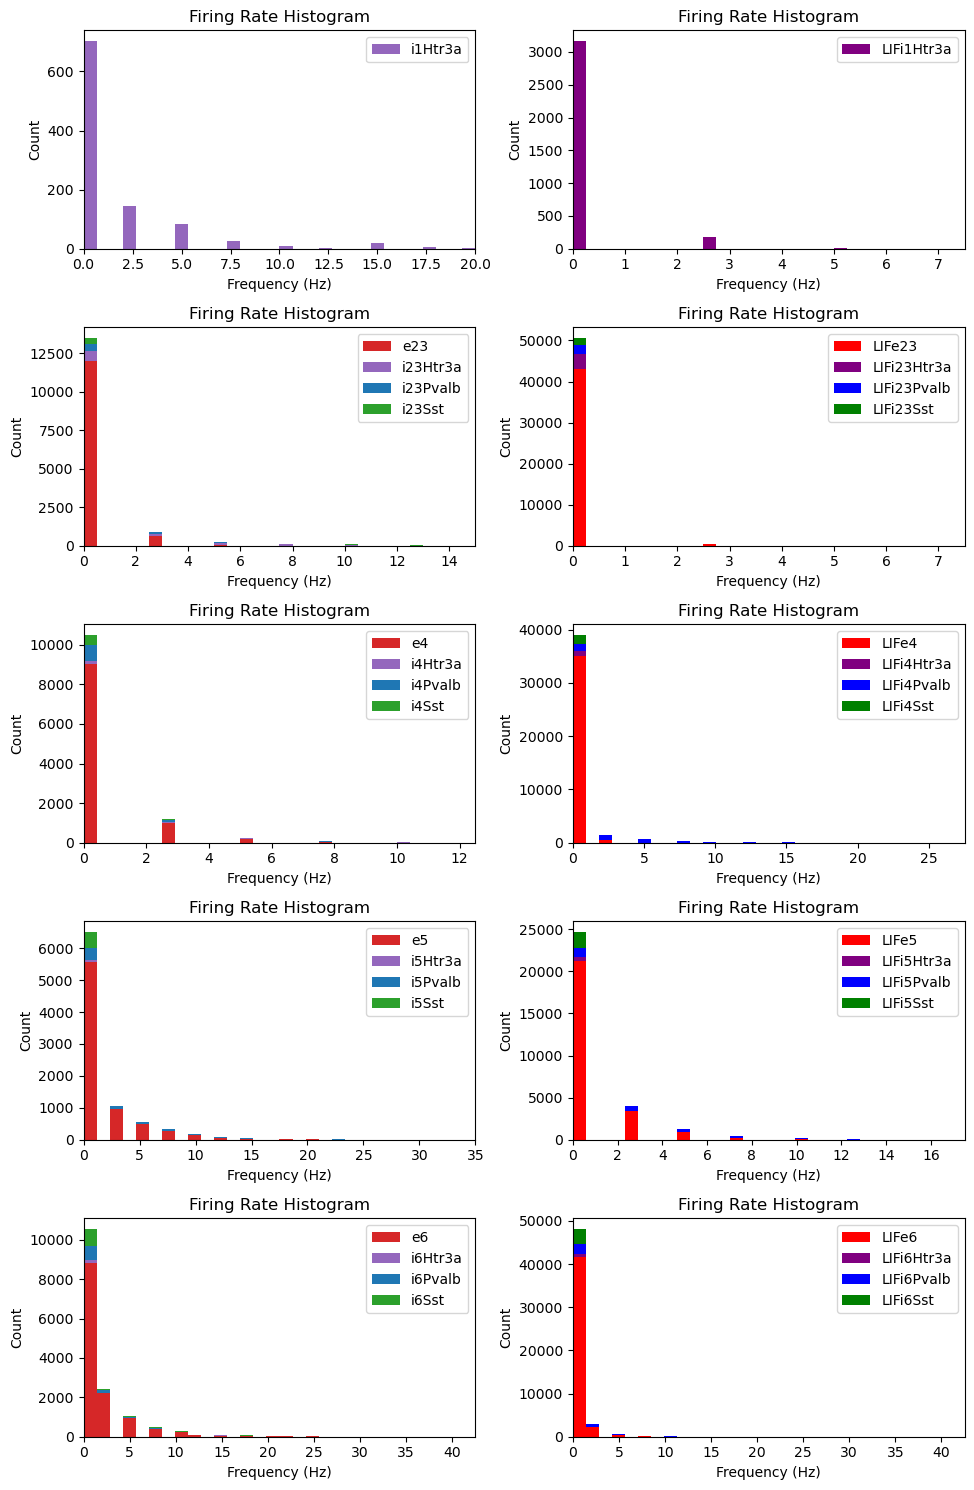

drifting_grating


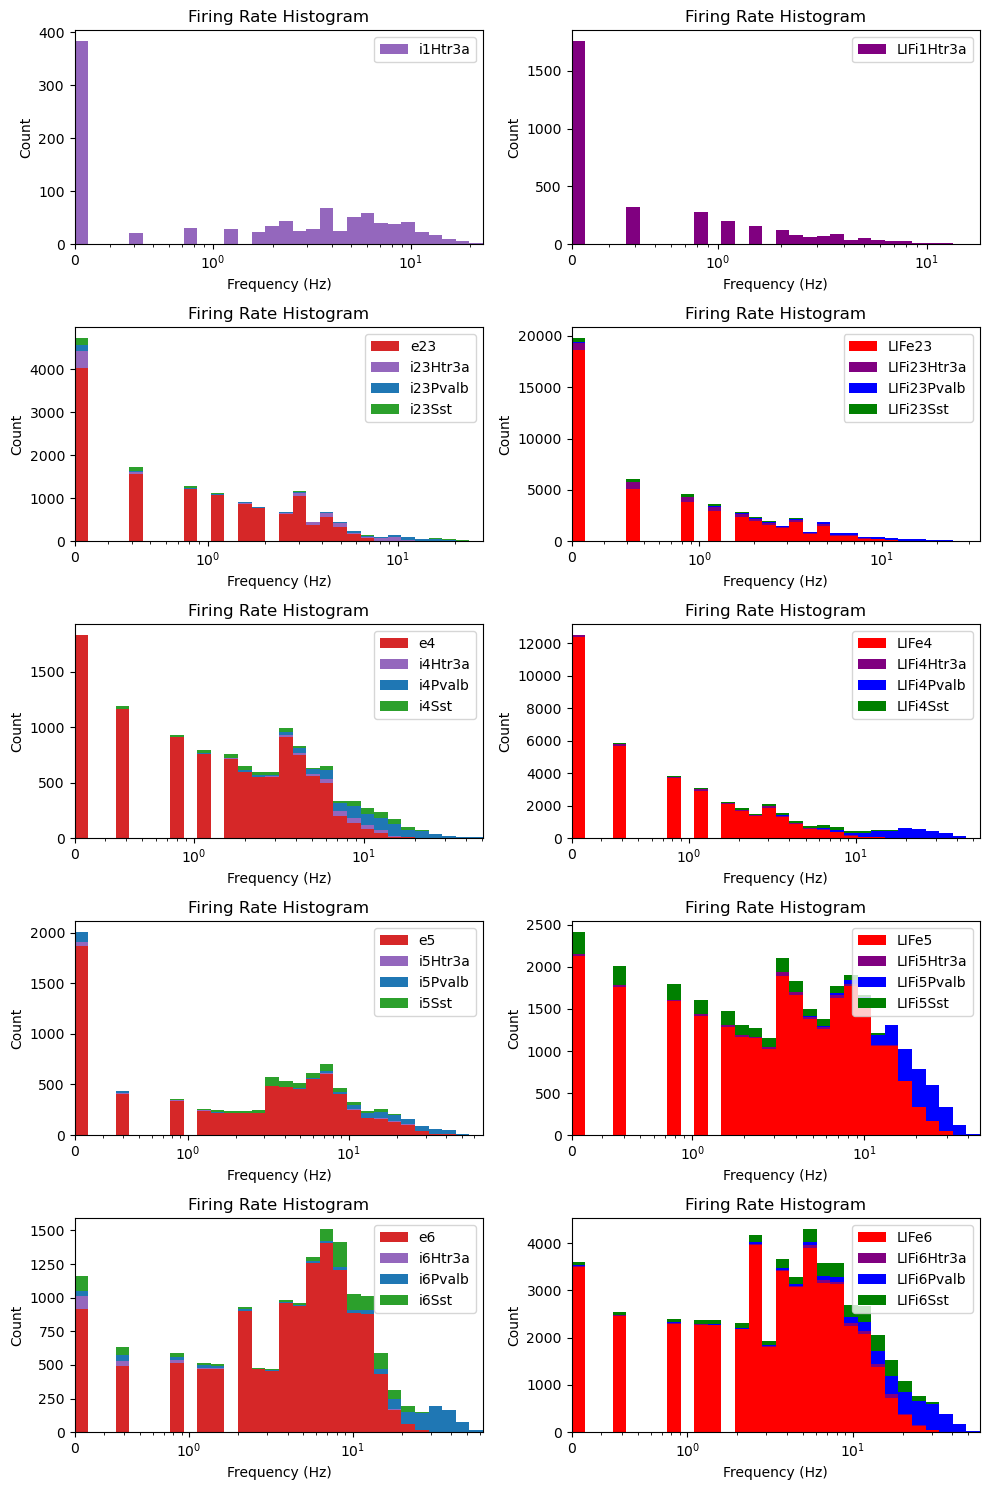

In [13]:
for dur in durations:
    print(dur)
    min_fr = 0.5 / process.total_duration(setting.duration_window[dur])
    _, axs = plt.subplots(len(layers), 2, figsize=(10, 3 * len(layers)))
    for j, M in enumerate(model_types):
        for i, L in enumerate(layers):
            ax = axs[i, j]
            pops = v1_pop_df.index[(v1_pop_df['layer'] == L) & (v1_pop_df['model_type'] == M)]
            pop_fr = {p: pop_frs[dur][p] for p in pops}
            plot.firing_rate_histogram(pop_fr, v1_pop_df.loc[pops, 'color'], bins=params['nbins'],
                                       min_fr=min_fr, logscale=setting.logscale_fr[dur], stacked=True, ax=ax)
    plt.tight_layout()
    plt.show()

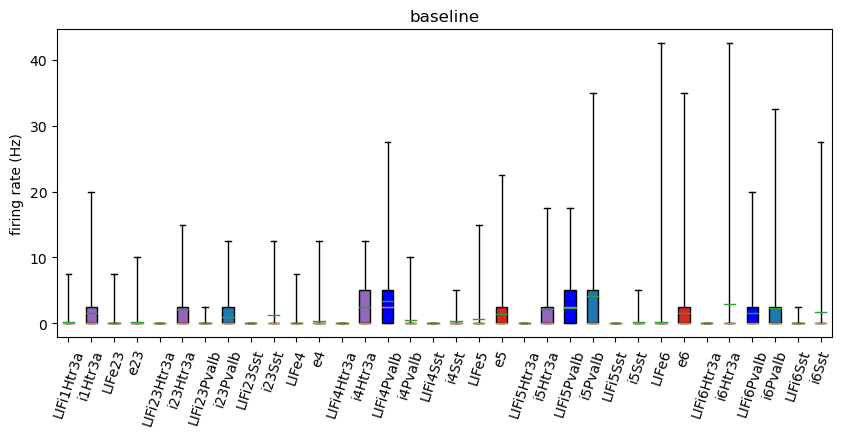

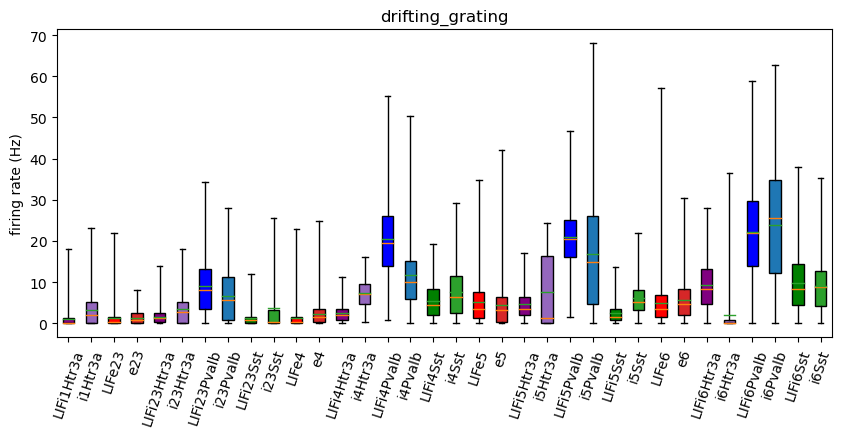

In [14]:
for dur in durations:
    plt.figure(figsize=(10, 4))
    pop_names = pop_frs[dur].keys()
    bplot = plt.boxplot(pop_frs[dur].values(), labels=pop_names, whis=(0., 100.),
                        showmeans=True, meanline=True, showfliers=False, showcaps=True,
                        widths=0.5, patch_artist=True,  # fill with color
                        meanprops={'linestyle': '-'})
    for patch, color in zip(bplot['boxes'], v1_pop_df.loc[pop_names, 'color']):
        patch.set_facecolor(color)
    plt.ylabel('firing rate (Hz)')
    plt.xticks(rotation=72, ha='center')
    plt.title(dur)
plt.show()

### Population spike rate time histogram

In [15]:
with open(config_file, 'r') as f:
    config = json.load(f)

time = np.array([0, config['run']['tstop'], params['dt']]) # ms
pop_rspk = {p: process.pop_spike_rate(spk['timestamps'], time) for p, spk in {**pop_spike_bio, **pop_spike_lif}.items()}

In [16]:
spike_rate_file = os.path.join(trial_dir, 'spike_rate.h5')
with h5py.File(spike_rate_file, 'w') as f:
    f.create_dataset('time', data=time)
    grp = f.create_group('populations')
    for p, rspk in pop_rspk.items():
        pop = grp.create_group(p)
        pop.create_dataset('data', data=rspk)
        pop.attrs['number'] = len(v1_pop_ids[p])

### PSD of LGN spikes

In [17]:
model_dir = '../V1_bio/'
lgn_spike_file = os.path.normpath(os.path.join(model_dir, config['inputs']['LGN_spikes']['input_file']))

with h5py.File(lgn_spike_file) as f:
    lgn_spikes_df = pd.DataFrame({
        'node_ids': f['spikes']['gids'],
        'timestamps': f['spikes']['timestamps']
    })

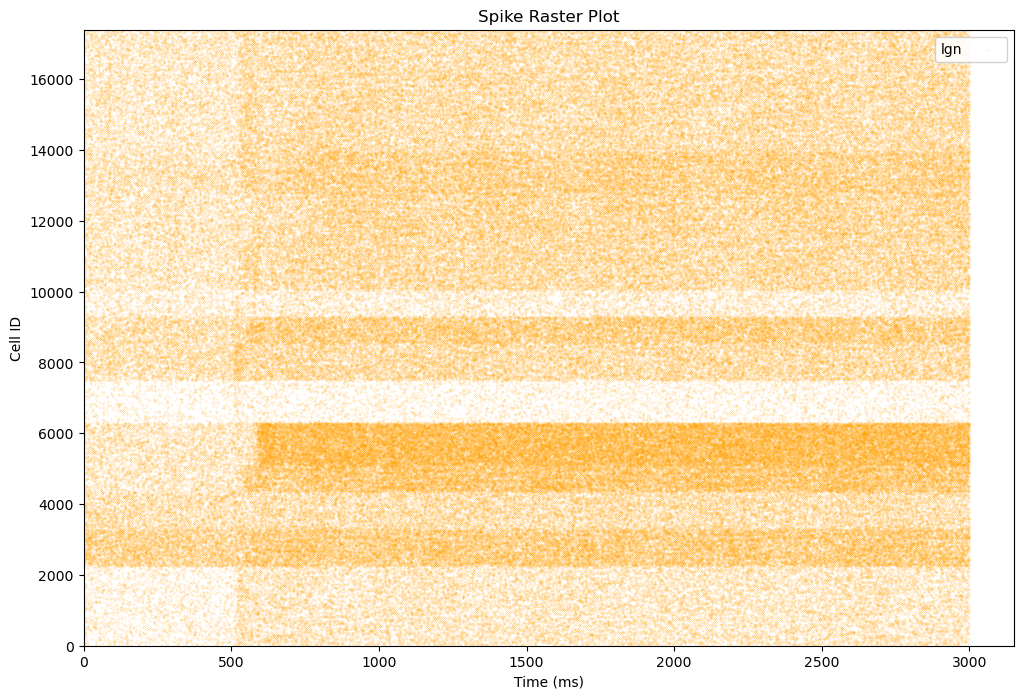

In [18]:
_, ax = plt.subplots(1, 1, figsize=(12, 8))
_ = plot.raster({'lgn': lgn_spikes_df}, {'lgn': 'orange'}, s=0.01, ax=ax)
plt.show()

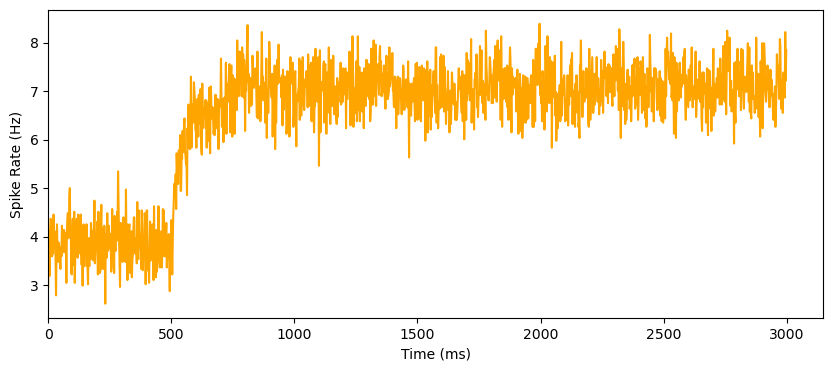

In [19]:
lgn_rspk = process.pop_spike_rate(lgn_spikes_df['timestamps'], time, frequeny=True) / lgn_spikes_df['node_ids'].max()
lgn_rspk = xr.DataArray(lgn_rspk, coords={'time': np.arange(*time)}).assign_attrs(fs=1000 / time[2])


plt.figure(figsize=(10, 4))
plt.plot(lgn_rspk.time, lgn_rspk, color='orange')
plt.xlim(left=0)
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (Hz)')
plt.show()

baseline


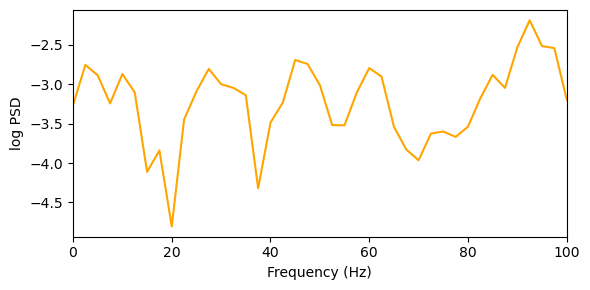

drifting_grating


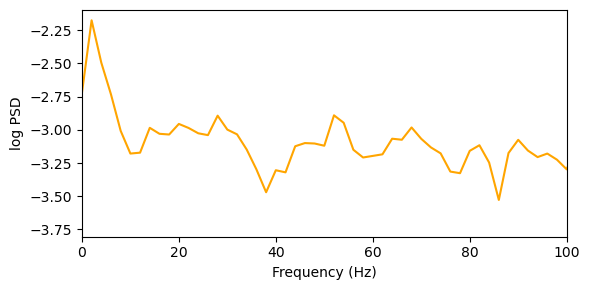

In [20]:
tseg = 0.5  # sec
freq_range = (0., 100.)

for dur in durations:
    print(dur)
    time_window = np.array(setting.duration_window[dur]) # ms
    nperseg = int(min(time_window[1] - time_window[0], tseg) * lgn_rspk.fs)
    time_window *= 1000.
    f, pxx = ss.welch(lgn_rspk.sel(time=slice(*time_window)).values, fs=lgn_rspk.fs, nperseg=nperseg)
    plt.figure(figsize=(6, 3))
    plt.plot(f, np.log10(pxx), 'orange')
    plt.xlim(freq_range)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log PSD')
    plt.tight_layout()
    plt.show()